In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from bokeh.plotting import figure, output_file, show, output_notebook
from bokeh.models import Span
from shapely.geometry import Point
import geopandas as gpd
import glob
from datetime import datetime
import bokeh
from bokeh.layouts import Row, column, gridplot
from bokeh.models import Title, Legend, TapTool, Range1d, Tabs, Panel
import matplotlib as mpl

from bokeh.core.validation.warnings import EMPTY_LAYOUT, MISSING_RENDERERS
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)

{Warning(code=1000, name='MISSING_RENDERERS', description='Plot has no renderers'),
 Warning(code=1002, name='EMPTY_LAYOUT', description='Layout has no children')}

In [22]:
# define color palette
color_palette = [  '#4E79A7',  # Blue
    '#F28E2B',  # Orange
    '#E15759',  # Red
    '#76B7B2',  # Teal
    '#59A14F',  # Green
    '#EDC948',  # Yellow
    '#B07AA1',  # Purple
    '#FF9DA7',  # Pink
    '#9C755F',  # Brown
    '#BAB0AC',  # Gray
    '#7C7C7C',  # Dark gray
    '#6B4C9A',  # Violet
    '#D55E00',  # Orange-red
    '#CC61B0',  # Magenta
    '#0072B2',  # Bright blue
    '#329262',  # Peacock green
    '#9E5B5A',  # Brick red
    '#636363',  # Medium gray
    '#CD9C00',  # Gold
    '#5D69B1',  # Medium blue
]

In [20]:
bokeh.core.validation.silence(EMPTY_LAYOUT, True)

def get_line_plot(businessActivity,title, source, earthquakes=True, subtitle=None):

    p2 = figure(x_axis_type = 'datetime', width = 800, height = 400, toolbar_location='above')
    p2.add_layout(Legend(), "right")

    for id, adm2 in enumerate(businessActivity['NAME_2'].unique()):

        df1 = businessActivity[businessActivity['NAME_2']==adm2][['date', 'no_coverage']].reset_index(drop=True)

        p2.line(df1['date'], df1['no_coverage'], line_width=2, line_color = color_palette[id], legend_label=adm2)

    p2.legend.click_policy='hide'
    if subtitle is not None:
        p2.title = subtitle


    title_fig = figure(title=title, toolbar_location=None,width=800, height=40, )
    title_fig.title.align = "left"
    title_fig.title.text_font_size = "12pt"
    title_fig.border_fill_alpha = 0
    title_fig.outline_line_width=0

    #with silence(MISSING_RENDERERS):
    sub_title = figure(title=source, toolbar_location=None,width=800, height=40, )
    sub_title.title.align = "left"
    sub_title.title.text_font_size = "10pt"
    sub_title.title.text_font_style="normal"
    sub_title.border_fill_alpha = 0
    sub_title.outline_line_width=0

    layout = column(title_fig, p2, sub_title)

    # if earthquakes:
    #     p2.renderers.extend([
    #     Span(
    #         location=datetime(2023, 9, 8),
    #         dimension="height",
    #         line_color='#7C7C7C',
    #         line_width=2,
    #         line_dash=(4,4)
    #   )
#         # Span(
#         #     location=datetime(2023, 2, 20),
#         #     dimension="height",
#         #     line_color='#7C7C7C',
#         #     line_width=2,
#         #     line_dash=(4,4)
#         # ),
#      ]
#  )

    return layout

# Meta Network Coverage Maps


Network Coverage Maps show where people on Facebook have cellular connectivity. This data provides critical information about gaps in cellular network coverage after natural disasters for the purpose of restoring connectivity as well as determining where aid workers and communities will be able to communicate.

## Data Collection and Methodology

This is determined based on the types of cell sites that users connect to in order to update their Facebook app’s data, which causes data to be sent between a user's device and the Facebook servers that host the app. In other words, this measures the estimated range, approximate coverage area and type of network connection based on the cell site IDs and locations that the users’ devices report. It is not based on data obtained from telecommunication services.

**Active Network Coverage**
This map shows which grid tiles in the region of interest had network coverage on that date. More precisely, we estimate which grid tiles had at least one cell site active on a given day. We assume a cell site is active on a day if we see at least one user pinging that cell site on that date.

**Network Coverage Undetected**
This map shows which grid tiles we are not certain of having network coverage on that date because no users’ devices reported connecting to cell sites there, but where we have observed coverage during the 30-day baseline period. We compare the maximum area where we observed some network coverage in the last 30 days, subtract the areas that had active coverage today and highlight the difference in this map.


**Data aggregation**: We publish this data in a grid format at Bing tile level 16. This is equivalent to roughly 600 meters on a side near the equator or the size of 2 city blocks.

We estimate if a grid tile lies inside the coverage areas of the nearby cell sites to determine if that tile is served by network coverage. To get the probability score of network coverage at a grid tile, we aggregate the independent probability scores attributed to all nearby cell sites serving that tile.

## Limitations

Population sample: Only the data from Facebook users who have turned on the Location Services device setting on their mobile device contribute to these maps. In regions with few such users, estimates become more uncertain.

Data considerations: In areas affected by a crisis, it is very difficult to distinguish between a nonoperational cell site and one that didn't receive signals because users have left the area.

We rely on a phone's reporting of cell IDs, and we have found that different phone models occasionally report different cell IDs for the same physical base station. This leads to overcounting the number of cell sites covering a grid tile.

In addition, those incorrect cell IDs lead to fewer location samples for the correct cell ID and create additional unreliable coverage polygons for the incorrectly reported cell IDs. As we rely on “last known location” for our coverage area estimates, discrepancies between the actual location and the reported location of a user’s device may be included in the samples for any given cell site, especially when the cell site is close to an airport.

In [3]:
all_files = glob.glob('../../data/network_coverage/undetected/*.csv')

networkUndetected = pd.DataFrame()

li = []

for file in all_files:
    df1 = pd.read_csv(file)
    df1['date'] = datetime.strptime(file.split('_')[2], '%Y-%m-%d')
    li.append(df1)

networkUndetected = pd.concat(li, axis=0)


In [4]:
all_files = glob.glob('../../data/network_coverage/*.csv')

networkDetected = pd.DataFrame()

li = []

for file in all_files:
    df1 = pd.read_csv(file)
    #print(file.split('_')[2])
    df1['date'] = datetime.strptime(file.split('_')[2], '%Y-%m-%d')
    li.append(df1)

networkDetected = pd.concat(li, axis=0)


In [5]:
morocco_adm2 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_2.shp')
morocco_adm1 = gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_1.shp')
morocco_adm4= gpd.read_file('../../data/shapefiles/gadm41_MAR_shp/gadm41_MAR_4.shp')

In [6]:
earthquake_intensity = gpd.read_file('../../data/earthquake/shape/mi.shp')
ei_adm4 = morocco_adm4[['NAME_4','NAME_3','NAME_2','NAME_1','geometry']].sjoin(earthquake_intensity[['PARAMVALUE', 'geometry']])
gdf_adm4 = morocco_adm4[['NAME_4','NAME_3','NAME_2','NAME_1','geometry']].sjoin(earthquake_intensity[['PARAMVALUE', 'geometry']])

In [7]:
geometry = [Point(xy) for xy in zip(networkDetected['lon'], networkDetected['lat'])]
networkDetected = gpd.GeoDataFrame(networkDetected, geometry=geometry)

geometry = [Point(xy) for xy in zip(networkUndetected['lon'], networkUndetected['lat'])]
networkUndetected = gpd.GeoDataFrame(networkUndetected, geometry=geometry)

In [8]:
color_dict = {'Network Undetected':'blue', 'Network Detected':'green'}

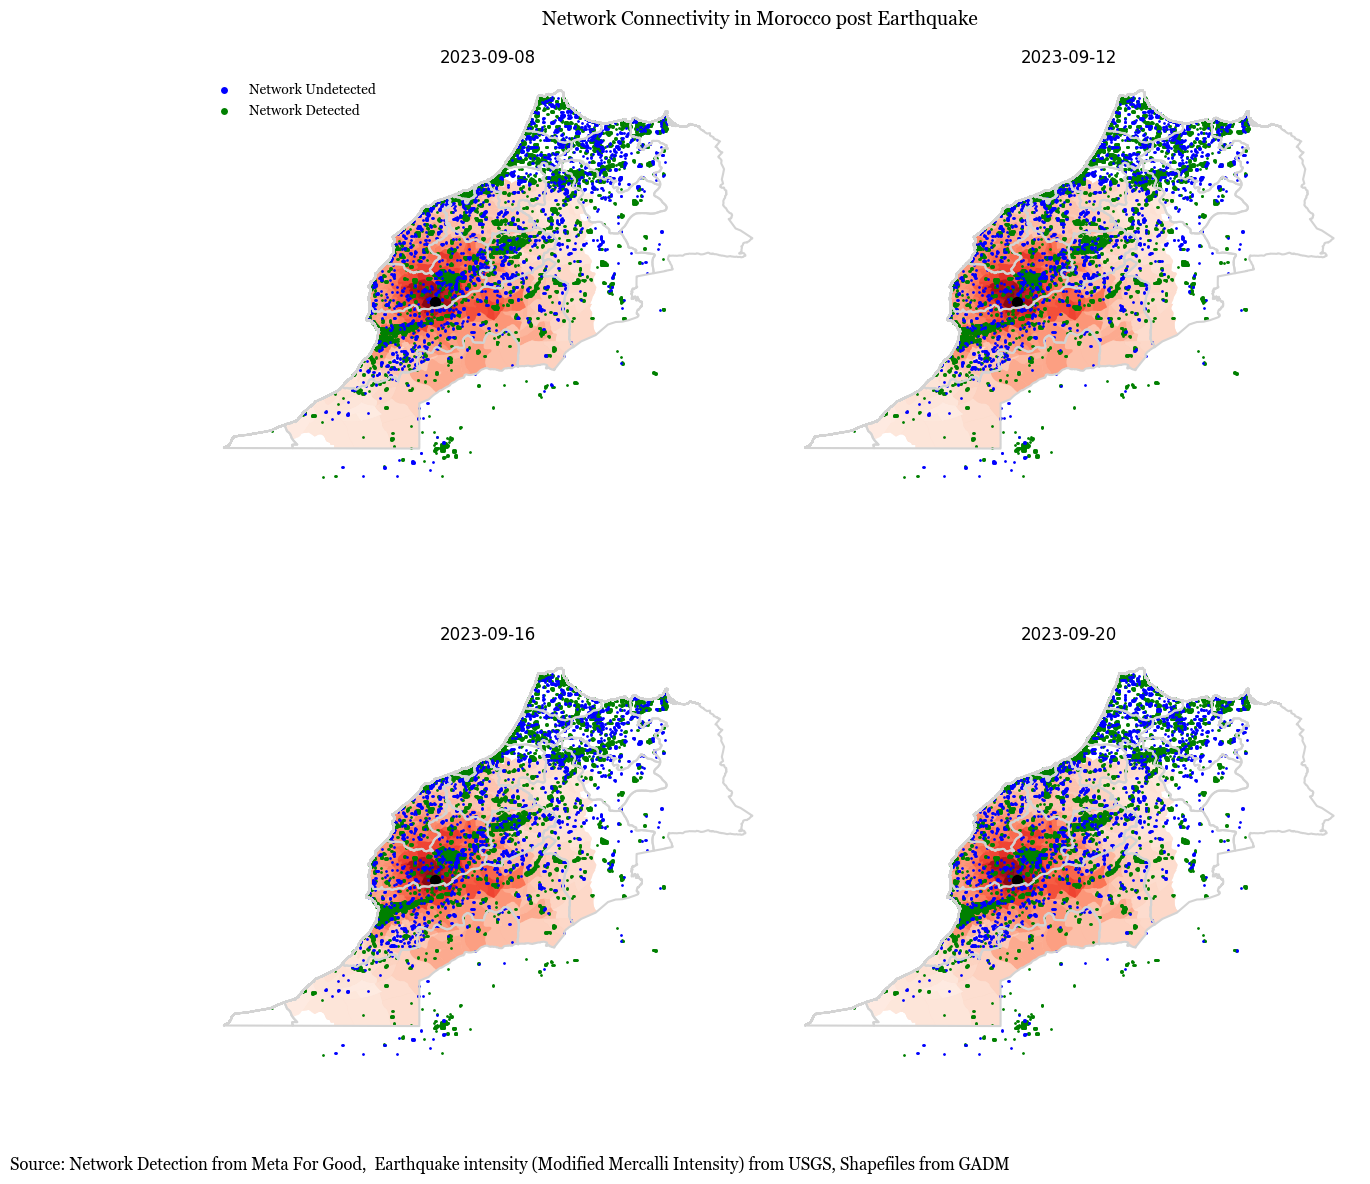

In [9]:
fig, axs = plt.subplots(2,2, figsize=(15,15),  gridspec_kw={'hspace': 0.00003})
ax = axs.flatten()
from matplotlib.lines import Line2D

plt.rcParams["font.family"] = "Georgia"

for id, date in enumerate(['2023-09-08', '2023-09-12', '2023-09-16', '2023-09-20']):
    ei_adm4.plot(column='PARAMVALUE', cmap = 'Reds', ax=ax[id],alpha = 0.5)
    morocco_adm1.boundary.plot(ax=ax[id], color = 'lightgrey')
    networkDetected[networkDetected['date']==date].plot(ax=ax[id], color = 'green', markersize=1, label = 'Network Detected', legend = True)
    networkUndetected[networkUndetected['date']==date].plot(ax=ax[id], color = 'blue', markersize=1, label = 'Network Not Detected', legend = True)

    x, y =gdf_adm4[gdf_adm4['PARAMVALUE']== gdf_adm4['PARAMVALUE'].max()]['geometry'].iloc[0].centroid.x, gdf_adm4[gdf_adm4['PARAMVALUE']== gdf_adm4['PARAMVALUE'].max()]['geometry'].iloc[0].centroid.y

    ax[id].scatter(x, y, c='black', marker='o', s=50)
    
    ax[id].set_title(date)

    ax[id].spines['top'].set_visible(False)
    ax[id].spines['bottom'].set_visible(False)
    ax[id].spines['right'].set_visible(False)
    ax[id].spines['left'].set_visible(False)

    ax[id].set_xticks([])
    ax[id].set_yticks([])

    legend_labels = ['Network Undetected', 'Network Detected']
    handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color_dict[label]) for label in legend_labels]
    ax[0].legend(handles=handles, loc='upper left',  frameon=False)

main_title = fig.suptitle('Network Connectivity in Morocco post Earthquake', fontsize = 14)
main_title.set_y(0.87)

subtitle = f'Source: Network Detection from Meta For Good,  Earthquake intensity (Modified Mercalli Intensity) from USGS, Shapefiles from GADM'

fig.text(0, 0.1, subtitle, ha='left', va='center', fontsize=12, color='black', weight='normal')

plt.subplots_adjust(hspace=0, wspace=0) 

plt.show()

In [10]:
networkDetected_adm2 = morocco_adm2.sjoin(networkDetected)
networkUndetected_adm2 = morocco_adm2.sjoin(networkUndetected)

c:\Users\sahit\anaconda3\envs\lebanon-economic-monitor\lib\site-packages\geopandas\geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
c:\Users\sahit\anaconda3\envs\lebanon-economic-monitor\lib\site-packages\geopandas\geodataframe.py:2177: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [11]:
networkDetected_adm2 = networkDetected_adm2.groupby(['date', 'NAME_2', 'NAME_1']).sum()[['coverage']].reset_index()
networkUndetected_adm2 = networkUndetected_adm2.groupby(['date', 'NAME_2', 'NAME_1']).sum()[['no_coverage']].reset_index()

In [23]:
output_notebook()
bokeh.core.validation.silence(EMPTY_LAYOUT, True)
bokeh.core.validation.silence(MISSING_RENDERERS, True)


tabs = []

for adm in morocco_adm1['NAME_1'].unique():
    df = networkUndetected_adm2[networkUndetected_adm2['NAME_1']==adm] 
    df = df.groupby(['NAME_1', 'date', 'NAME_2']).sum('no_coverage').reset_index()

    tabs.append(
        Panel(
        child=get_line_plot(df, f"Grid Plots with Undetected Network", "Source: Data for Good Meta", earthquakes=True, subtitle = '600m plot network post earthquake compared to 90 day prior baseline'),
                    title=adm.capitalize(),
                )
                )

tabs = Tabs(tabs=tabs, sizing_mode="scale_both")
show(tabs, warn_on_missing_glyphs=False)

Loading BokehJS ...